In [1]:
!pip uninstall -y numpy scipy scikit-learn albumentations

!pip install "numpy==1.26.4" "scipy==1.13.1" scikit-learn opencv-python-headless

!pip install protobuf==3.20.3 transformers==4.30.0 accelerate nltk rouge-score

import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import BertTokenizer, BertModel
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Install evaluation metrics libraries
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from torch.optim.lr_scheduler import ReduceLROnPlateau
import cv2
import matplotlib.pyplot as plt


nltk.download('punkt', quiet=True)

# Reproducibility - Ensure reproducible results
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 42
seed_everything(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Configuration
BASE_DIR = '/kaggle/input/vqa-rad-visual-question-answering-radiology'
JSON_PATH = os.path.join(BASE_DIR, 'VQA_RAD Dataset Public.json')
IMAGE_DIR = os.path.join(BASE_DIR, 'VQA_RAD Image Folder')

# Hyperparameters
LEARNING_RATE = 1e-4 
EPOCHS = 10           
IMG_SIZE = 384 
BATCH_SIZE = 16  
MAX_LEN = 32

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: albumentations 2.0.8
Uninstalling albumentations-2.0.8:
  Successfully uninstalled albumentations-2.0.8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 107.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 53.9 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
def apply_clahe_preprocessing(image):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    img_np = np.array(image)
    
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    limg = cv2.merge((cl, a, b))
    final_img_np = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    return Image.fromarray(final_img_np)


In [3]:
# ==========================================
# Data Processing & Mapping
# ==========================================
import json
with open(JSON_PATH, 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)

# Data cleaning
df['image_name'] = df['image_name'].astype(str)
df['question'] = df['question'].astype(str)
df['answer'] = df['answer'].astype(str).str.lower().str.strip()

# Build answer dictionary (Answer to ID mapping)
answer_counts = df['answer'].value_counts()
unique_answers = sorted(answer_counts.index.tolist())
if '<unk>' in unique_answers:
    unique_answers.remove('<unk>')
unique_answers = ['<unk>'] + unique_answers
ans_to_idx = {ans: i for i, ans in enumerate(unique_answers)}
idx_to_ans = {i: ans for i, ans in enumerate(unique_answers)}
NUM_CLASSES = len(unique_answers)

print(f"Total Unique Answers (Classes): {NUM_CLASSES}")
print(f"Example Classes: {unique_answers[:5]}")

# ==========================================
# Split by Image ID (ensure same image in one set)
# ==========================================
# Get unique image IDs
unique_img_ids = df['image_name'].unique()

# Split image IDs: 80% train, 10% validation, 10% test
train_ids, temp_ids = train_test_split(unique_img_ids, test_size=0.2, random_state=SEED)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=SEED)

# Create dataframes based on image IDs
train_df = df[df['image_name'].isin(train_ids)].reset_index(drop=True)
val_df = df[df['image_name'].isin(val_ids)].reset_index(drop=True)
test_df = df[df['image_name'].isin(test_ids)].reset_index(drop=True)

print(f"Total Rows: {len(df)}")
print(f"Train Rows: {len(train_df)} (Images: {len(train_ids)})")
print(f"Val Rows: {len(val_df)} (Images: {len(val_ids)})")
print(f"Test Rows: {len(test_df)} (Images: {len(test_ids)})")

# Simple oversampling: duplicate open-ended questions once to boost representation
open_mask = train_df['answer_type'].fillna('').str.upper() == 'OPEN'
open_df = train_df[open_mask].copy()
if len(open_df) > 0:
    train_df = pd.concat([train_df, open_df], ignore_index=True)
    train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    print(f"Train Rows After Open-Ended Duplication: {len(train_df)} (Duplicated {len(open_df)} OPEN samples)")
else:
    print("No OPEN samples found for duplication.")

# ==========================================
# Custom Dataset Class
# ==========================================
class VQADataset(Dataset):
    def __init__(self, df, img_dir, tokenizer, transform=None, max_len=64, ans_map=None):
        self.df = df
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len
        self.ans_map = ans_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image_name']
        question = row['question']
        answer = row['answer']

        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE))

        image = apply_clahe_preprocessing(image)

        if self.transform:
            image = self.transform(image)

        inputs = self.tokenizer(
            question,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )

        unk_idx = self.ans_map['<unk>']
        label = self.ans_map.get(answer, unk_idx)

        return {
            'image': image,
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }
        
        
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), 
    transforms.RandomRotation(15),           
    transforms.RandomHorizontalFlip(p=0.3),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create data loaders
train_dataset = VQADataset(
    train_df, 
    IMAGE_DIR, 
    tokenizer, 
    transform=train_transform, 
    max_len=MAX_LEN, 
    ans_map=ans_to_idx
)

val_dataset = VQADataset(
    val_df, 
    IMAGE_DIR, 
    tokenizer, 
    transform=val_transform, 
    max_len=MAX_LEN, 
    ans_map=ans_to_idx
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2
)

Total Unique Answers (Classes): 518
Example Classes: ['<unk>', '10-20 minutes', '12', '2', '2.5cm x 1.7cm x 1.6cm']
Total Rows: 2248
Train Rows: 1831 (Images: 251)
Val Rows: 210 (Images: 31)
Test Rows: 207 (Images: 32)
Train Rows After Open-Ended Duplication: 2597 (Duplicated 766 OPEN samples)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
# ==========================================
# Baseline Model Architecture
# ==========================================
class MedVQABaseline(nn.Module):
    def __init__(self, num_classes):
        super(MedVQABaseline, self).__init__()
        
        # Image encoder: ResNet-50
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.img_fc = nn.Linear(2048, 512)
        
        # Text encoder: BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.text_fc = nn.Linear(768, 512)
        
        # Fusion and classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512 + 512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, images, input_ids, attention_mask):
        # Extract image features
        img_features = self.resnet(images)
        img_features = img_features.view(img_features.size(0), -1)
        img_features = self.img_fc(img_features)
        
        # Extract text features
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = bert_output.pooler_output
        text_features = self.text_fc(text_features)
        
        # Concatenate features
        combined = torch.cat((img_features, text_features), dim=1)
        
        # Classification
        output = self.classifier(combined)
        return output

# Initialize model
model = MedVQABaseline(num_classes=NUM_CLASSES)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=ans_to_idx['<unk>'])

# Training Loop 
print("Start Training Baseline Model...")
best_acc = 0.0
UNFREEZE_EPOCH = 3 

LR_WARMUP = 1e-3      
LR_FINETUNE = 1e-5   

# freeze Pre-trained Layers
for param in model.resnet.parameters():
    param.requires_grad = False
for param in model.bert.parameters():
    param.requires_grad = False

print(f"Initial Phase: ResNet and BERT are FROZEN. Training only Classifier head.")

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_WARMUP, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Track metrics for visualization
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(EPOCHS):
    if epoch == UNFREEZE_EPOCH:
        print(f"\n[Info] Reaching Epoch {epoch+1}. Unfreezing all layers for Fine-tuning...")
        
        for param in model.parameters():
            param.requires_grad = True
            
        optimizer = optim.Adam(model.parameters(), lr=LR_FINETUNE, weight_decay=1e-5)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
        print(f"[Info] Model Unfrozen. Learning Rate set to {LR_FINETUNE}")

    # Standard Training Phase
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    status = "Frozen" if epoch < UNFREEZE_EPOCH else "Fine-tune"
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [{status}]"):
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_acc = 100 * correct / total
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)
    
    print(f"Epoch {epoch+1} - Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_total_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_total_loss / len(val_loader)
    val_accs.append(val_acc)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1} - Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Scheduler Step
    scheduler.step(avg_val_loss)
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "baseline_best_model.pth")
        print("-> Best Model Saved!")

print(f"Training Complete. Best Val Accuracy: {best_acc:.2f}%")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start Training Baseline Model...
Initial Phase: ResNet and BERT are FROZEN. Training only Classifier head.


Epoch 1/10 [Frozen]: 100%|██████████| 163/163 [00:55<00:00,  2.96it/s]

Epoch 1 - Loss: 4.9996, Train Acc: 20.29%


Epoch 1 - Val Loss: 4.6883, Val Acc: 20.48%
-> Best Model Saved!


Epoch 2/10 [Frozen]: 100%|██████████| 163/163 [00:52<00:00,  3.13it/s]

Epoch 2 - Loss: 4.6461, Train Acc: 20.18%


Epoch 2 - Val Loss: 4.6142, Val Acc: 20.95%
-> Best Model Saved!


Epoch 3/10 [Frozen]: 100%|██████████| 163/163 [00:51<00:00,  3.16it/s]

Epoch 3 - Loss: 4.3415, Train Acc: 21.52%


Epoch 3 - Val Loss: 4.8739, Val Acc: 21.43%
-> Best Model Saved!

[Info] Reaching Epoch 4. Unfreezing all layers for Fine-tuning...
[Info] Model Unfrozen. Learning Rate set to 1e-05


Epoch 4/10 [Fine-tune]: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]

Epoch 4 - Loss: 3.8632, Train Acc: 23.22%


Epoch 4 - Val Loss: 4.0188, Val Acc: 21.43%


Epoch 5/10 [Fine-tune]: 100%|██████████| 163/163 [00:58<00:00,  2.76it/s]

Epoch 5 - Loss: 3.6889, Train Acc: 24.41%


Epoch 5 - Val Loss: 3.9553, Val Acc: 21.90%
-> Best Model Saved!


Epoch 6/10 [Fine-tune]: 100%|██████████| 163/163 [00:59<00:00,  2.75it/s]

Epoch 6 - Loss: 3.6267, Train Acc: 25.53%


Epoch 6 - Val Loss: 3.8600, Val Acc: 26.67%
-> Best Model Saved!


Epoch 7/10 [Fine-tune]: 100%|██████████| 163/163 [00:58<00:00,  2.78it/s]

Epoch 7 - Loss: 3.5600, Train Acc: 26.18%


Epoch 7 - Val Loss: 4.0388, Val Acc: 30.48%
-> Best Model Saved!


Epoch 8/10 [Fine-tune]: 100%|██████████| 163/163 [00:59<00:00,  2.75it/s]

Epoch 8 - Loss: 3.4813, Train Acc: 28.42%


Epoch 8 - Val Loss: 3.7947, Val Acc: 30.00%


Epoch 9/10 [Fine-tune]: 100%|██████████| 163/163 [00:58<00:00,  2.77it/s]

Epoch 9 - Loss: 3.4005, Train Acc: 31.34%


Epoch 9 - Val Loss: 3.7803, Val Acc: 34.76%
-> Best Model Saved!


Epoch 10/10 [Fine-tune]: 100%|██████████| 163/163 [00:59<00:00,  2.76it/s]


Epoch 10 - Loss: 3.3293, Train Acc: 34.23%
Epoch 10 - Val Loss: 3.8640, Val Acc: 33.81%
Training Complete. Best Val Accuracy: 34.76%


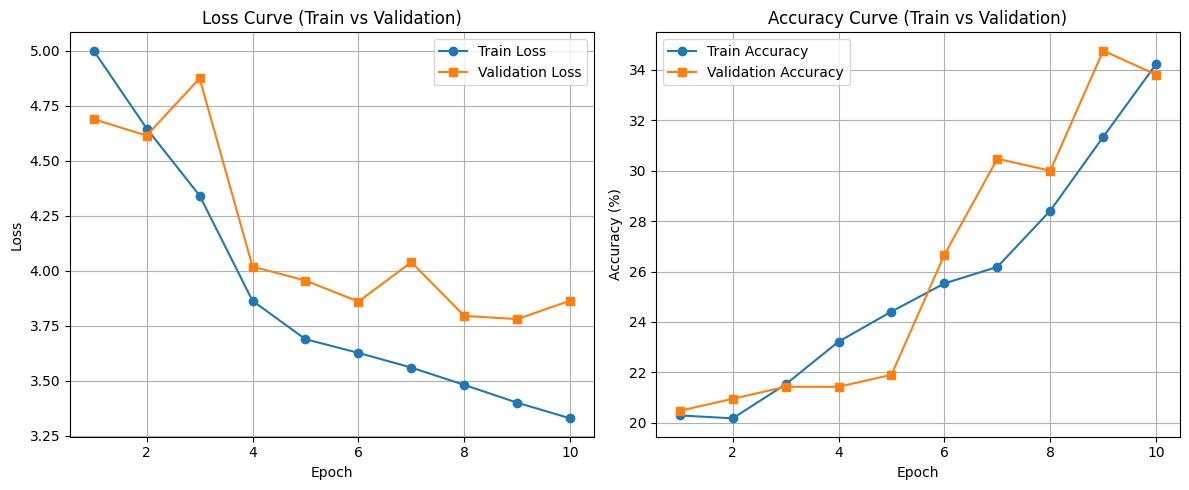

Training curves saved as 'training_curves.png'


In [7]:
import matplotlib.pyplot as plt

# Loss Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses, marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve (Train vs Validation)')
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_accs, marker='o', label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), val_accs, marker='s', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve (Train vs Validation)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved as 'training_curves.png'")

In [8]:
# Load best model
model.load_state_dict(torch.load("baseline_best_model.pth"))
model.eval()

# Collect predictions on validation set
all_preds = []
all_labels = []
all_indices = []

with torch.no_grad():
    for batch_idx, batch in enumerate(val_loader):
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(images, input_ids, attention_mask)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_indices.extend([batch_idx * BATCH_SIZE + i for i in range(len(labels))])

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Create evaluation dataframe
val_df_eval = val_df.reset_index(drop=True)
val_df_eval['pred'] = [idx_to_ans[p] for p in all_preds]
val_df_eval['pred_idx'] = all_preds
val_df_eval['is_correct'] = (all_preds == all_labels)

In [ ]:
import string
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics import precision_recall_fscore_support

def clean_text(text):
    text = str(text).lower().strip()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# ==========================================
# Prepare cleaned text
# ==========================================
val_df_eval['pred_clean'] = val_df_eval['pred'].apply(clean_text)
val_df_eval['answer_clean'] = val_df_eval['answer'].apply(clean_text)

# ==========================================
# Closed-ended Accuracy 
# ==========================================
closed_mask = val_df_eval['answer_type'] == 'CLOSED'
closed_df = val_df_eval[closed_mask]

closed_correct = 0
for _, row in closed_df.iterrows():
    pred = row['pred_clean']
    gt = row['answer_clean']
    if gt in pred or pred in gt:
        closed_correct += 1

closed_acc = closed_correct / len(closed_df) if len(closed_df) > 0 else 0.0

valid_answers = ['yes', 'no']

closed_eval_df = closed_df[
    closed_df['answer_clean'].isin(valid_answers) &
    closed_df['pred_clean'].isin(valid_answers)
]

if len(closed_eval_df) > 0:
    y_true = closed_eval_df['answer_clean'].values
    y_pred = closed_eval_df['pred_clean'].values

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=['yes', 'no'],
        average='binary',
        pos_label='yes',
        zero_division=0
    )
else:
    precision = recall = f1 = 0.
    
# ==========================================
# Open-ended Metrics (Accuracy + BLEU + ROUGE)
# ==========================================
open_mask = val_df_eval['answer_type'] == 'OPEN'
open_df = val_df_eval[open_mask]

open_correct = 0
bleu_scores = []
rouge_l_scores = []

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
cc = SmoothingFunction()

for _, row in open_df.iterrows():
    pred = row['pred_clean']
    gt = row['answer_clean']

    # --- Accuracy ---
    if gt == pred or (len(gt) > 2 and gt in pred):
        open_correct += 1

    # --- BLEU ---
    ref_tokens = [gt.split()]
    pred_tokens = pred.split()
    if len(pred_tokens) == 0:
        bleu = 0.0
    else:
        bleu = sentence_bleu(
            ref_tokens,
            pred_tokens,
            weights=(0.5, 0.5),
            smoothing_function=cc.method1
        )
    bleu_scores.append(bleu)

    # --- ROUGE-L ---
    rouge_l = scorer.score(gt, pred)['rougeL'].fmeasure
    rouge_l_scores.append(rouge_l)

open_acc = open_correct / len(open_df) if len(open_df) > 0 else 0.0
avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0
avg_rouge = np.mean(rouge_l_scores) if rouge_l_scores else 0.0

# ==========================================
# Final Report
# ==========================================
print("=" * 60)
print("FINAL EVALUATION REPORT")
print("=" * 60)
print(f"Total Samples          : {len(val_df_eval)}")
print("-" * 40)
print(f"Closed-ended Accuracy  : {closed_acc * 100:.2f}%")
print(f"Precision              : {precision * 100:.2f}%")
print(f"Recall                 : {recall * 100:.2f}%")
print(f"F1-score               : {f1 * 100:.2f}%")
print("-" * 40)
print(f"Open-ended Accuracy    : {open_acc * 100:.2f}%")
print(f"Open-ended BLEU Score  : {avg_bleu * 100:.2f}")
print(f"Open-ended ROUGE-L     : {avg_rouge * 100:.2f}")
print("=" * 60)

FINAL EVALUATION REPORT
Total Samples          : 210
----------------------------------------
Closed-ended Accuracy  : 59.48%
Precision              : 69.23%
Recall                 : 61.02%
F1-score               : 64.86%
----------------------------------------
Open-ended Accuracy    : 5.32%
Open-ended BLEU Score  : 1.70
Open-ended ROUGE-L     : 5.74


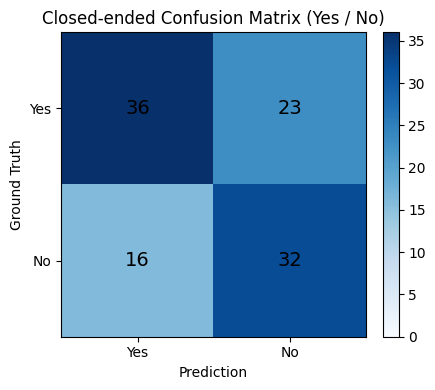

In [10]:
closed_df = val_df_eval[val_df_eval['answer_type'] == 'CLOSED'].copy()

valid_answers = ['yes', 'no']
closed_df = closed_df[
    closed_df['answer_clean'].isin(valid_answers) &
    closed_df['pred_clean'].isin(valid_answers)
]

cm = np.zeros((2, 2), dtype=int)

label_to_idx = {'yes': 0, 'no': 1}

for _, row in closed_df.iterrows():
    gt_idx = label_to_idx[row['answer_clean']]
    pred_idx = label_to_idx[row['pred_clean']]
    cm[gt_idx, pred_idx] += 1

fig, ax = plt.subplots(figsize=(5, 4))

im = ax.imshow(cm, cmap='Blues', vmin=0, vmax=np.max(cm))

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Yes', 'No'])
ax.set_yticklabels(['Yes', 'No'])

ax.set_xlabel("Prediction")
ax.set_ylabel("Ground Truth")
ax.set_title("Closed-ended Confusion Matrix (Yes / No)")

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=14, color='black')

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()



Correct Prediction Examples


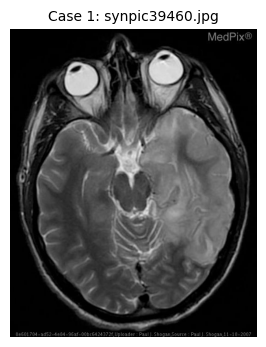

▶ Case 1 ( Correct)
  • Question     : Is there a skull fracture pictured?
  • Ground Truth : no
  • Prediction   : no
  • Answer Type  : CLOSED
------------------------------------------------------------


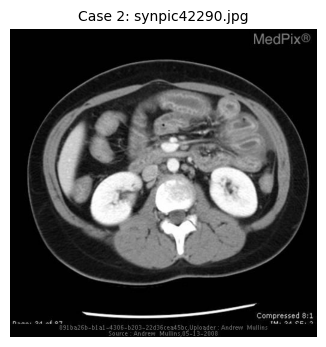

▶ Case 2 ( Correct)
  • Question     : Is the jejunal wall enlarged?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


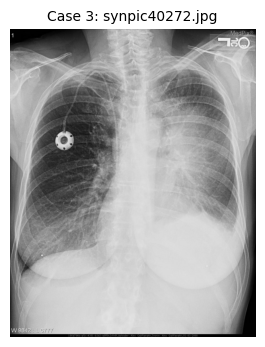

▶ Case 3 ( Correct)
  • Question     : Is the left lung field more radioopaque than the right side?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


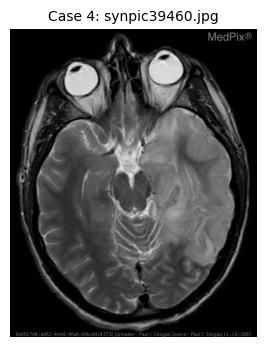

▶ Case 4 ( Correct)
  • Question     : Is there swelling of the grey matter?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


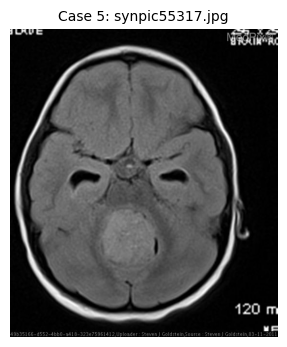

▶ Case 5 ( Correct)
  • Question     : Does this image display the CNS?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


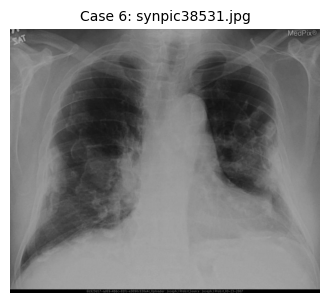

▶ Case 6 ( Correct)
  • Question     : Is there decreased aeration at the apex?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


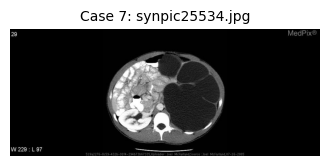

▶ Case 7 ( Correct)
  • Question     : Is there a small bowel obstruction?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


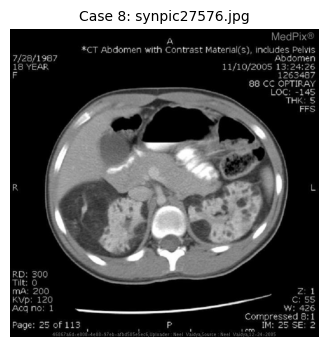

▶ Case 8 ( Correct)
  • Question     : Did the patient ingest contrast prior to taking this image?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


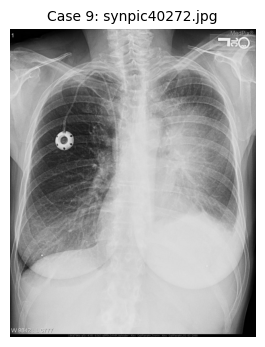

▶ Case 9 ( Correct)
  • Question     : was this chest x ray taken in PA format?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


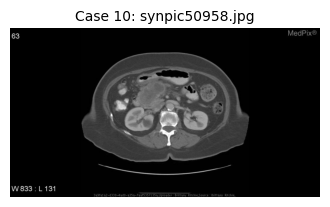

▶ Case 10 ( Correct)
  • Question     : Are any intestinal abnormalities present?
  • Ground Truth : no
  • Prediction   : no
  • Answer Type  : CLOSED
------------------------------------------------------------

Incorrect Prediction Examples


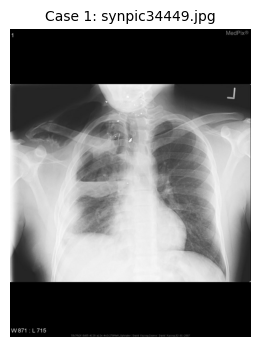

▶ Case 1 ( Incorrect)
  • Question     : How was this image taken?
  • Ground Truth : x-ray
  • Prediction   : no
  • Answer Type  : OPEN
------------------------------------------------------------


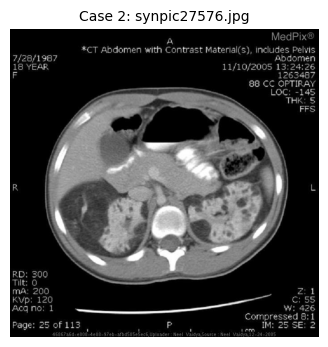

▶ Case 2 ( Incorrect)
  • Question     : What organ contains multiple lesions in the above image?
  • Ground Truth : kidneys
  • Prediction   : yes
  • Answer Type  : OPEN
------------------------------------------------------------


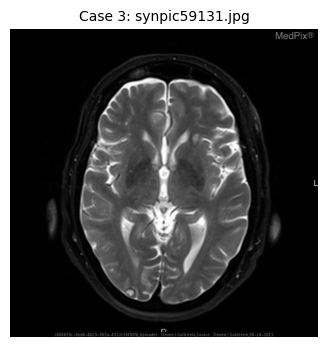

▶ Case 3 ( Incorrect)
  • Question     : Is there restricted diffusion?
  • Ground Truth : no
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


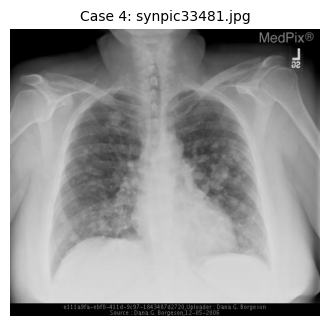

▶ Case 4 ( Incorrect)
  • Question     : What else do you need in order to localize lesions on a CXR?
  • Ground Truth : lateral film as well as pa
  • Prediction   : right
  • Answer Type  : OPEN
------------------------------------------------------------


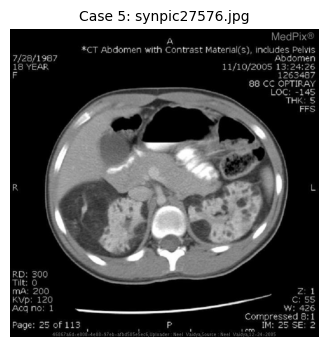

▶ Case 5 ( Incorrect)
  • Question     : Evidence of hemorrhage in the kidneys?
  • Ground Truth : no
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


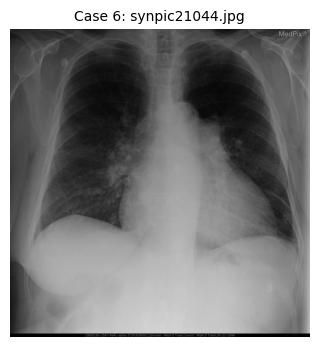

▶ Case 6 ( Incorrect)
  • Question     : Is there bilateral hilar enlargement?
  • Ground Truth : yes
  • Prediction   : no
  • Answer Type  : CLOSED
------------------------------------------------------------


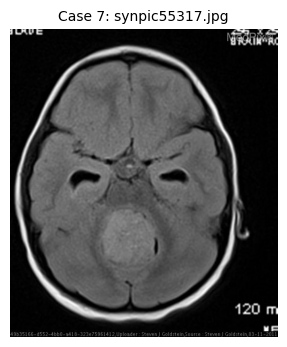

▶ Case 7 ( Incorrect)
  • Question     : Is this an MRI?
  • Ground Truth : yes
  • Prediction   : no
  • Answer Type  : CLOSED
------------------------------------------------------------


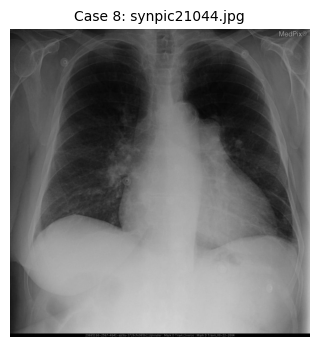

▶ Case 8 ( Incorrect)
  • Question     : Is the heart abnormal?
  • Ground Truth : yes
  • Prediction   : no
  • Answer Type  : CLOSED
------------------------------------------------------------


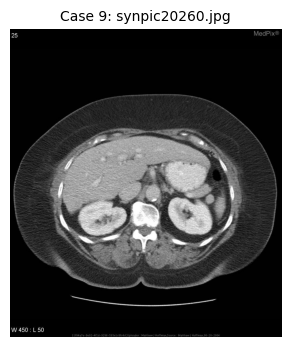

▶ Case 9 ( Incorrect)
  • Question     : What organ system is evaluated primarily?
  • Ground Truth : gi
  • Prediction   : axial
  • Answer Type  : OPEN
------------------------------------------------------------


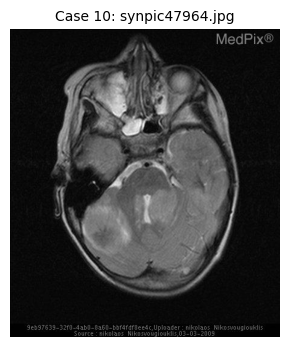

▶ Case 10 ( Incorrect)
  • Question     : Is there a shift of midline structures?
  • Ground Truth : yes
  • Prediction   : no
  • Answer Type  : CLOSED
------------------------------------------------------------


In [11]:
def visualize_vqa_point_form(df, img_dir, title, num_samples=3):
    if len(df) == 0:
        print(f"No samples found for: {title}")
        return

    samples = df.sample(min(num_samples, len(df)))

    print(f"\n{title}")
    print("=" * len(title))

    for i, (_, row) in enumerate(samples.iterrows(), 1):
        img_path = os.path.join(img_dir, row['image_name'])

        plt.figure(figsize=(4, 4))
        try:
            img = Image.open(img_path).convert("RGB")
            plt.imshow(img)
            plt.title(f"Case {i}: {row['image_name']}", fontsize=10)
        except:
            plt.text(0.5, 0.5, "Image Not Found", ha='center', va='center')
        plt.axis("off")
        plt.show()

        is_correct = row['pred_clean'] == row['answer_clean']
        status = " Correct" if is_correct else " Incorrect"

        print(f"▶ Case {i} ({status})")
        print(f"  • Question     : {row['question']}")
        print(f"  • Ground Truth : {row['answer']}")
        print(f"  • Prediction   : {row['pred']}")
        print(f"  • Answer Type  : {row['answer_type']}")
        print("-" * 60)


correct_examples = val_df_eval[
    val_df_eval['pred_clean'] == val_df_eval['answer_clean']
]

visualize_vqa_point_form(
    correct_examples,
    IMAGE_DIR,
    "Correct Prediction Examples",
    num_samples=10
)

incorrect_examples = val_df_eval[
    val_df_eval['pred_clean'] != val_df_eval['answer_clean']
]

visualize_vqa_point_form(
    incorrect_examples,
    IMAGE_DIR,
    "Incorrect Prediction Examples",
    num_samples=10
)